In [15]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
num = 2
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

## Likelihood Ratios

In [6]:
N = 10**6

# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, 0, 1)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model, 0, 1)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = pure_lr(mlc_model, 0, 1)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = pure_lr(sqr_model, 0, 1)

In [53]:
xs = np.linspace(-6, 6, 1201)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs, xs), xs) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs, xs), xs) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs, xs), xs) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs, xs), xs) + ('SQR',)

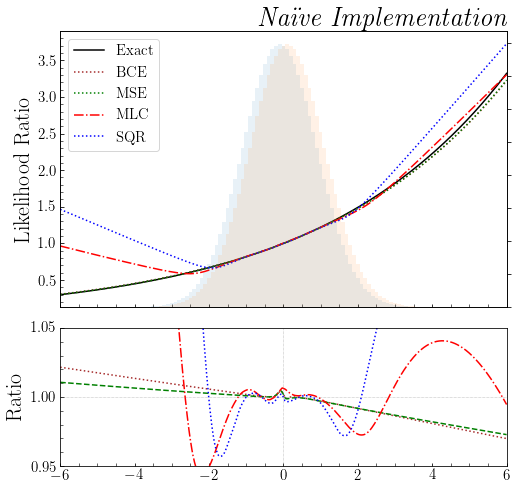

In [102]:
fig, axs = plt.subplots(2, 1,
                        figsize = (8, 8),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, bce_lr[0], c = 'brown', ls = ':', label = 'BCE')
axs[0].plot(xs, mse_lr[0], c = 'green', ls = ':', label = 'MSE')
axs[0].plot(xs, mlc_lr[0], c = 'red', ls = '-.', label = 'MLC')
axs[0].plot(xs, sqr_lr[0], c = 'blue', ls = ':', label = 'SQR')
axs[0].set_xlim(-6, 6)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticklabels([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, bce_lrr[0], c = 'brown', ls = ':')
axs[1].plot(xs, mse_lrr[0], c = 'green', ls = '--')
axs[1].plot(xs, mlc_lrr[0], c = 'red', ls = '-.')
axs[1].plot(xs, sqr_lrr[0], c = 'blue', ls = ':')
axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.title(r'\it Na\"ive Implementation', loc = 'right')
plt.savefig('plots/paper/naive_fit.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

## MAEs

In [98]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = pure_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = pure_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

100
1000
10000
100000
1000000
10000000


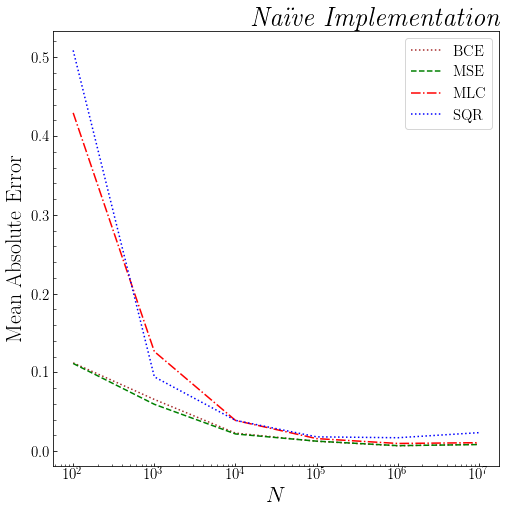

In [118]:
# Plot MAEs
fig, ax = plt.subplots(figsize = (8, 8))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='-.', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls=':', label='SQR')
plt.legend()

plt.minorticks_on()
plt.tick_params(axis = 'y', which = 'minor', length = 3)
plt.tick_params(which = 'both', direction='in')
plt.xscale("log", base=10)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r'\it Na\"ive Implementation', loc="right");
plt.savefig('plots/paper/naive_sizes.png',
            transparent = True,
            dpi=300, 
            bbox_inches='tight')